In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm


c:\Users\20175552\.conda\envs\flowmm\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def load_data(zeo):

    hoa_err = np.load(f'C:/Users/20175552/Code/porousequivariantnetworks/Data_Isotherms/Data_numpy_isothers2/{zeo}/hoa_err.npy')
    iso_params = np.load(f'C:/Users/20175552/Code/porousequivariantnetworks/Data_Isotherms/Data_numpy_isothers2/{zeo}/iso_params.npy')
    loads = np.load(f'C:/Users/20175552/Code/porousequivariantnetworks/Data_Isotherms/Data_numpy_isothers2/{zeo}/loads.npy')
    atoms = np.load(f'C:/Users/20175552/Code/porousequivariantnetworks/Data_Isotherms/Data_numpy_isothers2/{zeo}/atoms.npy')
    mask = hoa_err < 1.5

    # hoa_err = hoa_err[mask]
    iso_params = iso_params[mask]
    loads = loads[mask]
    atoms = atoms[mask]
    return iso_params, loads, atoms

In [3]:
def load_ats(cif):

    with open(cif, 'r') as f:
        lines = f.readlines()

    ats = []

    for line in lines:

        if line.startswith('Si'):
            ats.append(0)
        elif line.startswith('Al'):
            ats.append(1)
    
    return np.array(ats)

In [4]:
mfi_par, mfi_load, mfi_ats = load_data('MFI')
mor_par, mor_load, mor_ats = load_data('MOR')
itw_par, itw_load, _ = load_data('ITW')
mel_par, mel_load, _ = load_data('MEL')
ton_par, ton_load, _ = load_data('TON')

In [5]:
pars = [mor_par, mfi_par, mel_par, ton_par, itw_par]
loads = [mor_load, mfi_load, mel_load, ton_load, itw_load]
names = ['MOR', 'MFI', 'MEL', 'TON', 'ITW']

In [6]:
p = np.array([1, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000])[:,None] * 10
len(p)

12

In [7]:

def langmuir_freundlich_2s(p, x):
    '''
    Langmuir-Freundlich isotherm with two sites

    p (torch.Tensor): parameters of the model
    x (torch.Tensor): input data (pressure)
    '''
    return p[:,0]*p[:,1]*x**p[:,2]/(1.0+p[:,1]*x**p[:,2])+p[:,3]*p[:,4]*x**p[:,5]/(1.0+p[:,4]*x**p[:,5])

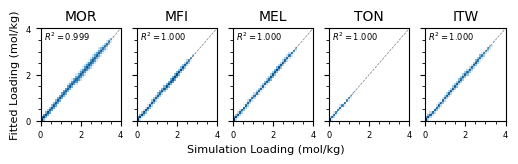

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(6, 1.2), sharex=True, sharey=True)

for i in range(5):

    pred_q = langmuir_freundlich_2s(pars[i], p).T.flatten()
    true_q = loads[i].flatten()

    pred_mean = np.mean(pred_q)
    ssr = np.sum((true_q - pred_q)**2)
    sst = np.sum((true_q - pred_mean)**2)

    r2 = 1 - ssr/sst

    ax[i].hist2d(true_q, pred_q, bins=np.linspace(0, 4, 40), cmap='Blues', norm=LogNorm())
    ax[i].set_xlim(0,4)
    ax[i].set_ylim(0,4)

    ax[i].text(0.15, 3.5, f'$R^2 = {r2:.3f}$', fontsize=6)

    ax[i].plot([0,4], [0,4], 'k--',lw=.5, alpha=.5)

    ax[i].set_yticks([0, 2, 4])
    ax[i].set_xticks([0, 2, 4])
    ax[i].set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5], minor=True)
    ax[i].set_yticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5], minor=True)
    ax[i].set_title(names[i], fontsize=10)

    if i == 0:
        ax[i].set_ylabel('Fitted Loading (mol/kg)', fontsize=8)

    ax[i].xaxis.set_tick_params(labelsize=6)
    ax[i].yaxis.set_tick_params(labelsize=6)

fig.text(0.5, -0.15, 'Simulation Loading (mol/kg)', ha='center', fontsize=8)
plt.savefig('si_figures/ruptura_parity.pdf', bbox_inches='tight')

In [74]:
def al_prop_to_si_al_ratio(prop):
    '''
    Convert the Al fraction to the Si/Al ratio
    '''
    return (1-prop)/prop

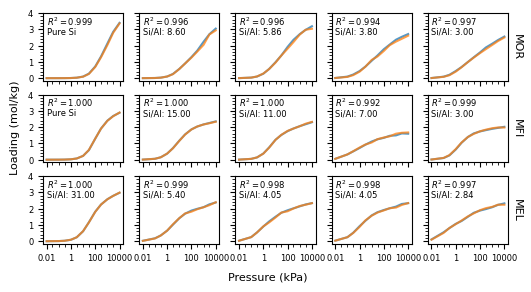

In [77]:
nums_mor = [4,1,0,3,2]
al_mor = [0, 5/48, 7/48, 10/48, 12/48]
nums_mfi = [0,3,1,2,4]
al_mfi = [0, 6/96, 8/96, 12/96, 24/96]
nums_mel = [507,1097,0,16,341]
al_mel = [3/96, 15/96, 19/96, 19/96, 25/96]

zeos = ['MOR', 'MFI', 'MEL']

fig, ax = plt.subplots(3, 5, figsize=(6, 3), sharex=True, sharey=True)

for i in range(len(zeos)):

    ax[i,4].set_ylabel(zeos[i], fontsize=8, rotation=270, labelpad=10)
    ax[i,4].yaxis.set_label_position('right')

    for j in range(5):
        
        if zeos[i] == 'MOR':
            nu = nums_mor[j]
            al_ats = al_mor[j]
        elif zeos[i] == 'MFI':
            nu = nums_mfi[j]
            al_ats = al_mfi[j]
        elif zeos[i] == 'MEL':
            nu = nums_mel[j]
            al_ats = al_mel[j]

        with open(f'validation/{zeos[i]}/reduced/sim-CO2-{zeos[i]}_{nu}-298K.load') as f:
            lines = f.readlines()[1:]

        
        with open(f'validation/{zeos[i]}/full/sim-CO2-{zeos[i]}_{nu}-298K.load') as f:
            lines2 = f.readlines()[1:]

        lines = [i.strip().split() for i in lines]
        lines2 = [i.strip().split() for i in lines2]

        p = np.log10([float(i[0]) for i in lines]) + 3
        # print(p)

        q_reduced = np.array([float(i[1]) for i in lines])
        q_full = np.array([float(i[1]) for i in lines2])


        red_mean = np.mean(q_reduced)

        ssr = np.sum((q_full - q_reduced)**2)
        sst = np.sum((q_full - red_mean)**2)

        r2 = 1 - ssr/sst

        ax[i,j].text(1, 3.25, f'$R^2 = {r2:.3f}$', fontsize=6)
        if (zeos[i] in ['MOR', 'MFI']) and j == 0:
            ax[i,j].text(1, 2.7, f'Pure Si', fontsize=6)
        else:
            sial = al_prop_to_si_al_ratio(al_ats)
            ax[i,j].text(1, 2.7, f'Si/Al: {sial:.2f}', fontsize=6)
        
        ax[i,j].plot(p, q_full, alpha=.75)
        ax[i,j].plot(p, q_reduced, alpha=.75)

        # ax[i,j].set_xscale('log')

        ps = np.array([1, 3, 5, 7])
        ax[i,j].set_xticks(ps, [0.01, 1, 100, 10000])
        ax[i,j].xaxis.set_tick_params(labelsize=6)

        ax[i,j].set_xticks([1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712], minor=True)
        ax[i,j].set_yticks([0, 1, 2, 3, 4])
        ax[i,j].set_yticks(np.arange(0, 4, 0.2), minor=True)

        ax[i,j].yaxis.set_tick_params(labelsize=6)


fig.text(0.5, -0.01, 'Pressure (kPa)', ha='center', fontsize=8)
fig.text(0.07, 0.5, 'Loading (mol/kg)', va='center', rotation='vertical', fontsize=8)

plt.savefig('si_figures/isotherm_validation.pdf', bbox_inches='tight')